In [1]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.lib import xla_bridge
from jax.lax import scan
from jax import random
import plotly.express as px
import MCsampler as mc

from matplotlib import gridspec
import matplotlib.pyplot as plt

# Normal distribution

In [2]:
@jit
def P(x):
    return jnp.exp(-(x-1)**2/(2*0.1))

In [3]:
sampler = mc.Metro_Has(P,1)

In [4]:
v_n = sampler.sample(2, 1000, burn = 50)

1206 points accepted in 6.898563644000205 s.


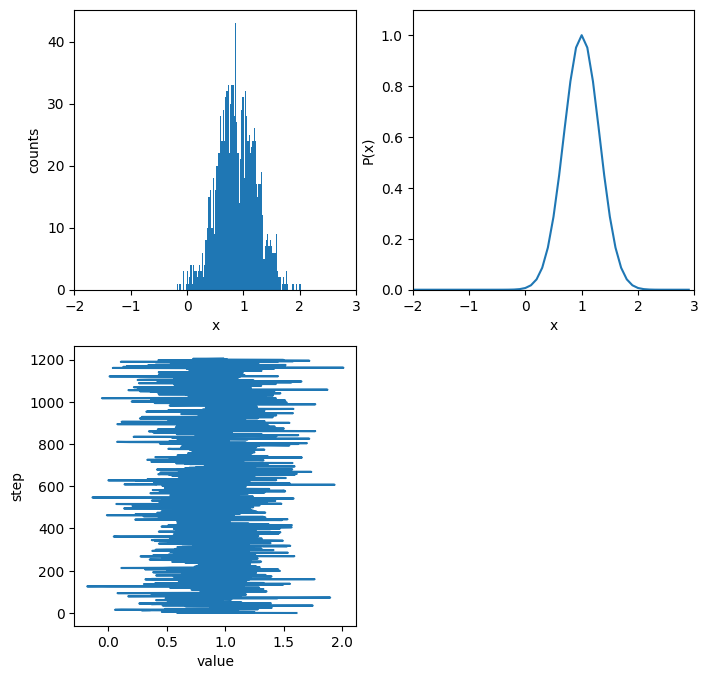

In [5]:
fig = plt.figure(figsize=(8, 8))

# Set up a 2x2 GridSpec
gs = gridspec.GridSpec(2, 2, figure=fig)

# Add three subplots in an "L" shape
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left

ax1.hist(v_n, bins = 100)
ax1.set_xlabel('x')
ax1.set_ylabel('counts')
ax1.set_xlim(-2,3)

ax2.plot(jnp.arange(-2,3,0.1),P(jnp.arange(-2,3,0.1)))
ax2.set_xlim(-2,3)
ax2.set_ylim(0,1.1)
ax2.set_xlabel('x')
ax2.set_ylabel('P(x)')


ax3.plot(v_n,jnp.arange(len(v_n)))
ax3.set_xlabel('value')
ax3.set_ylabel('step')

plt.show()

# Crazy distribution

In [6]:
@jit
def P(x):
    return jnp.exp(-x**2)*(2+jnp.sin(5*x)+jnp.sin(2*x))

In [7]:
sampler = mc.Metro_Has(P,1)

In [10]:
v = sampler.sample(1, 5000, burn = 50)

5189 points accepted in 8.589947555000435 s.


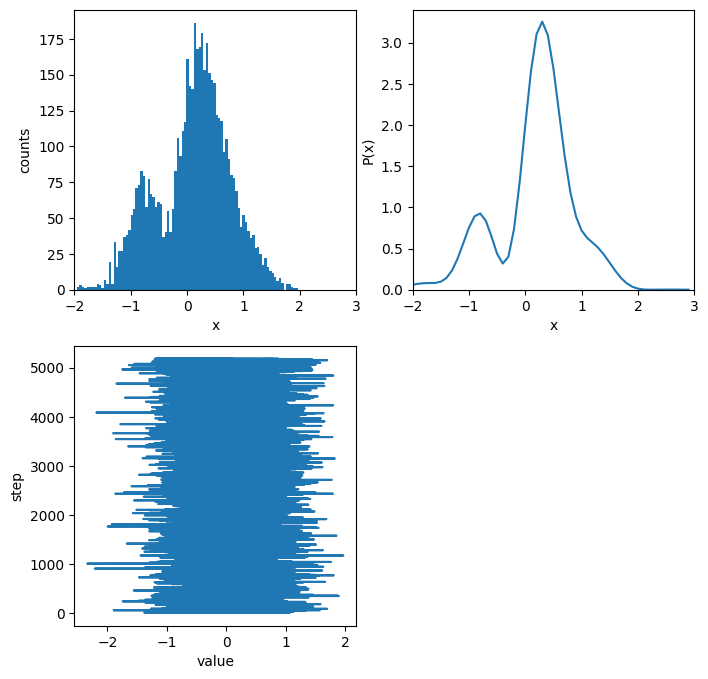

In [11]:
fig = plt.figure(figsize=(8, 8))

# Set up a 2x2 GridSpec
gs = gridspec.GridSpec(2, 2, figure=fig)

# Add three subplots in an "L" shape
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left

ax1.hist(v, bins = 100)
ax1.set_xlabel('x')
ax1.set_ylabel('counts')
ax1.set_xlim(-2,3)

ax2.plot(jnp.arange(-2,3,0.1),P(jnp.arange(-2,3,0.1)))
ax2.set_xlim(-2,3)
ax2.set_ylim(0,3.4)
ax2.set_xlabel('x')
ax2.set_ylabel('P(x)')

ax3.plot(v,jnp.arange(len(v)))
ax3.set_xlabel('value')
ax3.set_ylabel('step')

plt.show()

# Multivariate normal distribution

In [2]:
@jit
def P(x):
    covin = jnp.array([[1,0],[0,1]])
    mul = jnp.matmul(jnp.matmul(jnp.transpose(x),covin), x)
    det = 1/jnp.linalg.det(covin)
    return 1/(2*jnp.pi*jnp.sqrt(det))*jnp.exp(-1/2*mul)


In [3]:
sampler = mc.Metro_Has(P,2)

In [4]:
key1 = random.PRNGKey(0)
key2 = random.PRNGKey(1)

In [5]:
sampler.step(jnp.array([1,1]), key1, key2)

Array([0.21523404, 1.8564448 ], dtype=float32)

In [4]:
key = random.PRNGKey(0)

In [12]:
keys = random.split(key, 4  + 1)
key, *keys = keys
keys = jnp.array(keys).reshape(4, 2)

bkeys = random.split(key, 4+1)
key, *bkeys = bkeys
bkeys = jnp.array(bkeys).reshape(4, 2)

In [13]:
sampler.markov_chain(jnp.array([0,1]), keys, bkeys)

Array([], shape=(0,), dtype=float32)

In [9]:
import timeit

start = timeit.default_timer()
sampler = mc.MCMC(P,2)
v = sampler.sample(jnp.array([0,0]),1e3)

stop = timeit.default_timer()
dt = (stop - start) 

print(f'Time: {dt} s ') 

Burn stage finished
Time: 3.952652992000367 s 


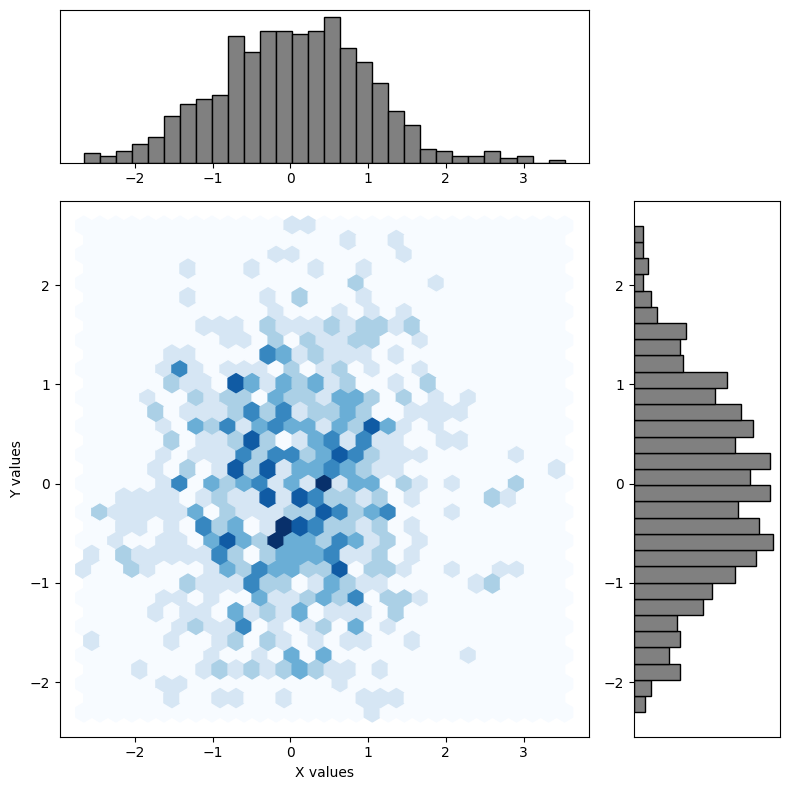

In [10]:
x = v[:,0]
y = v[:,1]

# Set up figure and layout
fig = plt.figure(figsize=(8, 8))  # Set figure size (width, height)
gs = gridspec.GridSpec(4, 4)      # Define grid for layout

# Density heatmap in the center
ax_main = fig.add_subplot(gs[1:4, 0:3])
hb = ax_main.hexbin(x, y, gridsize=30, cmap="Blues")  # or use plt.hist2d(x, y, bins=30, cmap="Blues")
ax_main.set_xlabel('X values')
ax_main.set_ylabel('Y values')

# Histogram for x (top marginal)
ax_x = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_x.hist(x, bins=30, color="gray", edgecolor="black")
ax_x.set_yticks([])  # Hide y-axis ticks for the marginal histogram

# Histogram for y (right marginal)
ax_y = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_y.hist(y, bins=30, orientation="horizontal", color="gray", edgecolor="black")
ax_y.set_xticks([])  # Hide x-axis ticks for the marginal histogram

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
jnp.amax(v)

Array(2.8927438, dtype=float32)

In [261]:
class Metro_Has():
    '''
        Implementation of the Metropolis-Hastings algorithm to sample from a distribution.

        Parameters:
            P (function): Distribution to be sampled.
            D (int): Dimensionality of base space.
        
    '''


    
    def __init__(self, P, D):
        super(Metro_Has, self).__init__()
        self.P = P
        self.key = random.key(0)
        self.D = D

    def draw_sample(self,x, key):
        '''
            Draws a sample from the proposal distribution, chosen to be a (multivariate) normal distribution with unit covariance.

            Parameters:
                x (array): Current state of the Markov chain.
                key (scalar array): PRNG key for the random generators.

            Returns:
                xp (array): Sample from the proposal distribution.

        '''
        
        if self.D == 1:
            xp = jax.random.normal(key)

        if self.D >1:
            xp = jax.random.multivariate_normal(key, x, jnp.array([[1,0],[0,1]]))
        return xp

    
    def Q(self, xp, x):
        '''
            Probability function of the proposal distribution, chosen to be a (multivariate) normal distribution with unit covariance.
        
            Parameters:
                xp (array): New proposed state of the Markov chain.
                x (array): Current state of the Markov chain.

            Returns:
                q (float): Probability of Q(xp|x).
        '''
        
        if self.D == 1:
            q = 1/jnp.sqrt(2*jnp.pi)*jnp.exp(-1/2*(x-xp)**2)
            
        elif self.D >1:
            exponent = -1/2*jnp.matmul(jnp.matmul(jnp.transpose((xp-x)), jnp.array([[1,0],[0,1]]) ), (xp-x))
            q = 1/(2*jnp.pi)**self.D/2 *jnp.exp(exponent)

        return q
        
    
    def acceptance(self, x, xp, key):
        '''
            Checks whether we accept or not the new proposed state in the Markov chain.

            Parameters:
                xp (array): New proposed state of the Markov chain.

            Returns:
                xp (array): Returns the value of xp when it is accepted. Otherwise it returns nothing.
            
        '''
        alpha = [1]
        alpha.append(self.P(xp)/self.P(x) * self.Q(xp,x)/self.Q(x,xp) )
        a = jnp.amin(jnp.array(alpha))
        
       
        u = random.uniform(key)
        
        self.x = jnp.where(u <= a, xp, self.x)
        xp = jnp.where(u > a, jnp.nan, xp)
        return xp
    
    def step(self, x0, key1, key2):

        xp = self.draw_sample(x0, key1)
        
        return self.acceptance(x0, xp, key2)


    def markov_chain(self, x0, keys, burning_keys):
        x_ac = []

        for i in range(len(burning_keys)):
            x_n = self.step(x0, burning_keys[2*i], burning_keys[2*i+1])
            x0 = jnp.where(~jnp.isnan(x_n), x_n, x0)
        
        for i in range(len(keys)):
            x_n = self.step(x0, keys[2*i], keys[2*i+1]) 
            x0 = jnp.where(~jnp.isnan(x_n), x_n, x0)

            x_ac.append(x_n)

        x_ac = jnp.stack(x_ac)

        return x_ac


    
    def sample(self, x0, Nc, N, burn = 100):
        '''
            Returns N samples from the distribution.

            Parameters:
                x0 (array): Initial state.
                N (int): Number of samples to be retrieved from the distribution.
                burn (int, optional): Number of steps in the burning stage. The default value is 100.

            Returns:
                xs (array): N samples of the target distribution.
        '''
        
        N = int(N)

        keys = random.split(sampler.key, 2*Nc*N+1)
        sampler.key = keys[0]
        keys = keys[1:].reshape(Nc,2*N)

        bkeys = random.split(sampler.key, 2*Nc*burn+1)
        sampler.key = bkeys[0]
        bkeys = bkeys[1:].reshape(Nc,2*burn)

        u = jax.vmap(self.markov_chain)(x0,keys,bkeys)

        u = u[~jnp.isnan(u)]
       
        return u

In [268]:
sampler = Metro_Has(P,1)
sampler.x = 1

In [269]:
keys = random.split(sampler.key, 3)
sampler.key = keys[0]
kk = keys[0:]
sampler.step(1,kk[0], kk[1])

Array(1.1188384, dtype=float32)

In [270]:
keys = random.split(sampler.key, 2*3+1)
sampler.key = keys[0]
keys = keys[1:]

In [271]:
sampler.markov_chain(1, keys, keys)[1]

Array(nan, dtype=float32)

In [272]:
v = sampler.sample(jnp.array([1,1,1,1,1]),5,50)

In [273]:
v.shape

(183,)

(array([50.,  3.,  2., 17., 18., 26., 32., 24.,  8.,  3.]),
 array([-1.69481564, -1.37727678, -1.05973792, -0.74219906, -0.42466021,
        -0.10712135,  0.21041751,  0.52795637,  0.84549522,  1.16303408,
         1.48057294]),
 <BarContainer object of 10 artists>)

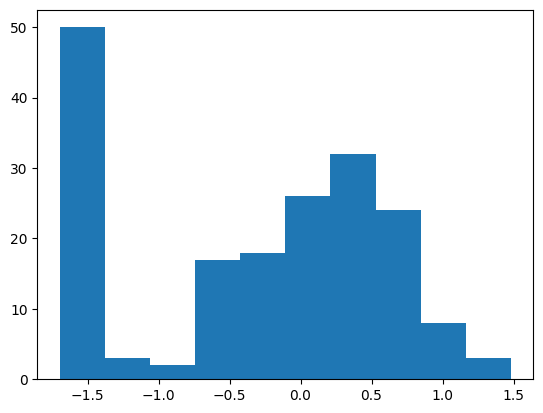

In [274]:
plt.hist(v)

In [13]:
keys = random.split(sampler.key, 2*2*2+1)
key, *keys = keys
keys = jnp.array(keys).reshape(2, 2 * 2, 2)

In [12]:
jnp.array(keys).shape

(8, 2)

In [14]:
keys

Array([[[ 166352884, 2530739410],
        [ 396685701, 1115604612],
        [3568991790, 2085090125],
        [ 142100644,  450340679]],

       [[ 432456088, 1753871416],
        [1730793538, 2674557089],
        [3699005084, 2242982404],
        [1444645704,  558580617]]], dtype=uint32)

In [7]:
jnp.concatenate((v,v))

Array([ 4.69621748e-01, -2.97488904e+00, -7.59334207e-01,  6.26678690e-02,
       -2.03247857e+00,  5.66946685e-01,  1.03036380e+00, -2.27645952e-02,
        2.64439546e-02, -3.54492217e-01,  1.05358601e+00, -6.76777542e-01,
        1.38063699e-01, -4.68528807e-01, -1.09427190e+00,  4.44239676e-01,
       -9.06397521e-01, -6.19410813e-01, -1.53019106e+00,  4.49498564e-01,
       -8.18126619e-01, -3.76671702e-01, -1.82758600e-01,  2.70133168e-01,
       -1.00743604e+00,  1.81029513e-01, -1.75416744e+00, -1.21188498e+00,
        2.76149243e-01,  4.96084839e-01, -4.04059231e-01,  1.42556322e+00,
       -3.95946592e-01,  2.57845223e-01,  3.01179737e-01, -1.82398245e-01,
       -1.09660649e+00, -4.44834530e-01,  6.29875720e-01,  9.21832025e-02,
        1.32683501e-01,  2.23104339e-02,  3.67595017e-01,  1.68251181e+00,
        4.82948661e-01, -1.53593266e+00, -1.20086920e+00, -1.00189579e+00,
       -1.17919230e+00,  8.05161893e-02, -3.04990768e+00, -5.34796059e-01,
       -1.64259017e+00, -

In [10]:
len(jnp.array([]))

0

In [5]:
v[-1]

NameError: name 'v' is not defined